### Segment Any change

In [12]:
from segment_any_change.main import SegAnyChange, load_img
from segment_any_change.utils import load_levircd_sample, show_img
from segment_any_change.mask_items import ImgType

import numpy as np
from typing import Union
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
def flush_memory():
    import gc
    import torch
    gc.collect()
    torch.cuda.empty_cache()
flush_memory()

In [4]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

In [5]:
def show_pair_img(img_A:  Union[str, np.ndarray], img_B: Union[str, np.ndarray]):
    if isinstance(img_A, str):
        img_A = load_img(img_A)
    if isinstance(img_B, str):
        img_B = load_img(img_B)
    pair = np.hstack((img_A, img_B))
    show_img(pair)

In [6]:
img_A = load_img(path_A)
img_B = load_img(path_B)

In [7]:
sam_params = {
    "points_per_side": 32,
    "points_per_batch": 64,
    "pred_iou_thresh": 0.88,
    "stability_score_thresh": 0.95,
    "stability_score_offset": 1.0,
    "box_nms_thresh": 0.7,
    "crop_n_layers": 0,
    "crop_nms_thresh": 0.7,
    "crop_overlap_ratio": 512 / 1500,
    "crop_n_points_downscale_factor":1,
    "point_grids": None,
    "min_mask_region_area": 0,
    "output_mode": "binary_mask",
}
segany = SegAnyChange(
    model_type="vit_h",
    **sam_params
)



In [8]:
res = segany.bitemporal_matching(
    img_A=load_img(path_A),
    img_B=load_img(path_B)
)

== process crops ==
== process batch for point : 64 ==
------
Output predict masks torch : torch.Size([64, 3, 1024, 1024])
init  masks data: 192
Output filter IoU masks data: 130
Output filter stability masks data: 82
Output filter mask_threshold: 82
Output filter boundary 82
== process batch for point : 64 ==
------
Output predict masks torch : torch.Size([64, 3, 1024, 1024])
init  masks data: 192
Output filter IoU masks data: 162
Output filter stability masks data: 76
Output filter mask_threshold: 76
Output filter boundary 76
== process batch for point : 64 ==
------
Output predict masks torch : torch.Size([64, 3, 1024, 1024])
init  masks data: 192
Output filter IoU masks data: 157
Output filter stability masks data: 60
Output filter mask_threshold: 60
Output filter boundary 60
== process batch for point : 64 ==
------
Output predict masks torch : torch.Size([64, 3, 1024, 1024])
init  masks data: 192
Output filter IoU masks data: 145
Output filter stability masks data: 51
Output filt

/home/MDizier/projects/stage_stylo_magique_2024/src/segment_any_change/embedding.py:10: RuntimeWarning: Mean of empty slice
  mask_embedding = np.nanmean(img_embedding*mask[None, ...], axis=(1, 2))
/home/MDizier/projects/stage_stylo_magique_2024/src/segment_any_change/matching.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return - (x1 @ x2) / (np.linalg.norm(x1)*np.linalg.norm(x2))


nan values ci 10
nan values ci1 11


#### Output SegAnyChange - deprecated return see src

In [9]:
masks_emb_t_mA = res["mask_embedding"]["t->t+1"][0]
masks_emb_t1_mA = res["mask_embedding"]["t->t+1"][1]

masks_emb_t_mB = res["mask_embedding"]["t+1->t"][0]
masks_emb_t1_mB = res["mask_embedding"]["t+1->t"][1]

In [10]:
img_emb_A = res["A"]["img_embedding"]
img_emb_B = res["B"]["img_embedding"]

In [11]:
mask_Af = res["A"]["global_mask"]
mask_Bf = res["B"]["global_mask"]

ci = res["conf"]["t->t+1"]
ci1 = res["conf"]["t+1->t"]

In [13]:
mask_A = segany.get_mask_proposal(ImgType.A)
mask_B = segany.get_mask_proposal(ImgType.B)

### Exploration modules Any Change

In [ ]:
print(np.linalg.norm(img_emb_A))
print(np.linalg.norm(img_emb_B))


In [ ]:
print(np.linalg.norm(masks_emb_t_mA[0]))
print(np.linalg.norm(masks_emb_t1_mA[0]))


In [ ]:
print(np.linalg.norm(masks_emb_t_mB[34]))
print(np.linalg.norm(masks_emb_t1_mB[34]))

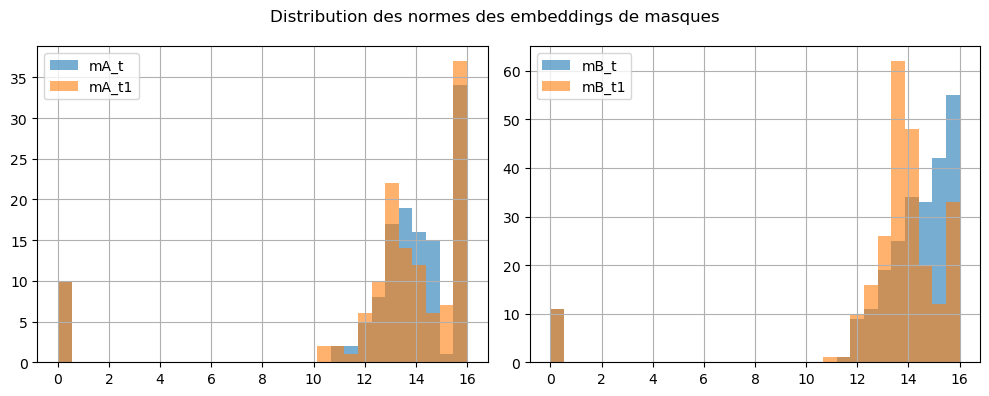

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

pd.Series([np.linalg.norm(_) for _ in masks_emb_t_mA]).hist(ax=axes[0], label="mA_t", alpha=0.6, bins=30)
pd.Series([np.linalg.norm(_) for _ in masks_emb_t1_mA]).hist(ax=axes[0], label="mA_t1", alpha=0.6, bins=30)
axes[0].legend()

pd.Series([np.linalg.norm(_) for _ in masks_emb_t_mB]).hist(ax=axes[1], label="mB_t", alpha=0.6, bins=30)
pd.Series([np.linalg.norm(_) for _ in masks_emb_t1_mB]).hist(ax=axes[1], label="mB_t1", alpha=0.6, bins=30)
axes[1].legend()

fig.suptitle("Distribution des normes des embeddings de masques")
plt.tight_layout()

* Investiguer vectur norm null
* shift mB_t1

In [19]:
np.sqrt(256)

16.0

### Visualisation des masques

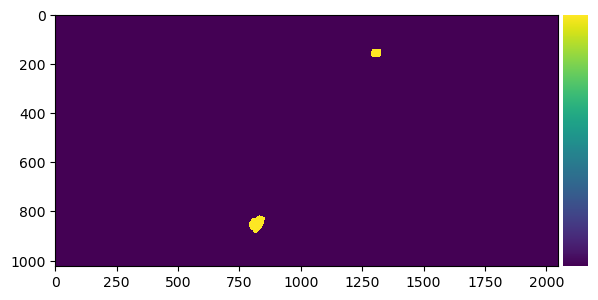

In [21]:
show_pair_img(mask_A[12], mask_B[12])

* Il faut un mapping spatial entre les masques A et B

* ci calculé via mask_A
* ciA calculé via mask_B

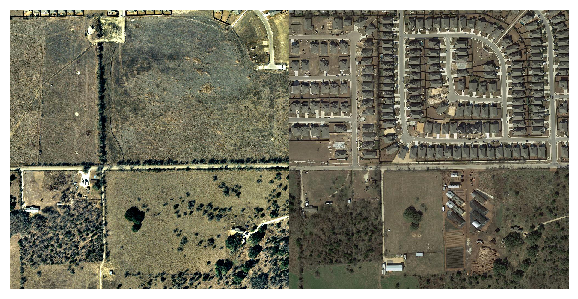

In [22]:
show_pair_img(img_A, img_B)

In [23]:
stack_mA = np.stack(mask_A)
stack_mB = np.stack(mask_B)

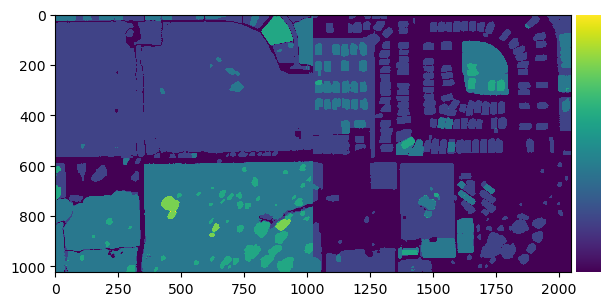

In [24]:
show_pair_img(
    np.sum(stack_mA, axis=0), 
    np.sum(stack_mB, axis=0)
)

### Fusion

##### Méthode 1 : individuals union (concat)
* Change proposal == 1 masque
* Filtrer les masques couvrant une même zone dans un second temps
* Pb :
    * 1 masque == 1 confidence score 
    * Pas vraiment de matching "bitemporal" => si via la similarité
 
      
##### Methode 2 : union geometry
* change proposal : union of mask on same area (same area to be define as a threshold)
* Pb :
    * Define threshold of Iou for Union
        * Union or selection of masks (min objets)
     
##### Methode 3 : individuals with union of score
* Change proposal == 1 masque
* Union (avg) des scores de confiance sur la zone
* Filtrer les masques couvrant une même zone dans un second temps

##### Methode 4 : concat and union of join masque
* join (union) geometry of same object mask (based on th IoU)
* otherwise consider 1 mask == 1 change proposal

Peut t on aggreger les ci avec les ci1 ? => pas les mêmes masks mais potentiellement les mêmes objets

* definition : 
    * zone de changement : définie une zone inter images

> The real-world change is defined at the same geographic location from time t to t + 1. This means that it is comparable only if two mask embeddings cover the approximate same geographic region

In [14]:
def rad_to_degre(x):
    return x*180/np.pi

def to_degre(x):
    return rad_to_degre(np.arccos(-x))

#### Methode 4

In [15]:
# identifcation of join areas
"""
join area == inter area == 0.8 of Union Area
"""

'\njoin area == inter area == 0.8 of Union Area\n'

In [16]:
from enum import Enum
class ImgType(Enum):
    A=1
    B=2

In [19]:
l = [1, 2, 3]
l.pop(0)

1

In [21]:
l.remove(2)

In [22]:
l

[3]

In [47]:
import itertools
from dataclasses import dataclass, field
from typing import List, Optional, Any, Dict, Optional



@dataclass
class ItemProposal:
    mask: np.ndarray
    confidence_score: float
    id: int = field(default_factory=itertools.count().__next__, init=False) # check how it works
    meta: List[Dict]
    chgt_angle: float = None
    from_img: List[ImgType]=None

    def __post_init__(self):
        if self.chgt_angle is None:
            self.chgt_angle = to_degre(self.confidence_score)
        
@dataclass
class ListProposal:
    items: Optional[List[ItemProposal]] = None
    index: int = 0

    def __post_init__(self) -> None:
        if self.items is None:
            self.items = []

    def add_item(self, item) -> None:
        if item.id not in [_.id for _ in self.items]:
            self.items.append(item)

    def rm_item(self, id: int) -> None:
        self.items = [_ for _ in self.items if _.id != id]

    def __getitem__(self, idx) -> ItemProposal:
        return self.items[idx]
    
    def __len__(self) -> int:
        return len(self.items)

        
def cover_same_zone(mask_A, mask_B, th=0.6) -> bool:
    inter_area = np.sum(np.logical_and(mask_A, mask_B))
    union_area = np.sum(np.logical_or(mask_A, mask_B))
    return inter_area > (union_area * th)

def create_union_object(item_A: ItemProposal, item_B: ItemProposal) -> ItemProposal:
    # filter on sim before merge ?
    return ItemProposal(mask=np.logical_or(item_A.mask, item_B.mask).astype(np.uint8), 
                        confidence_score=np.mean([item_A.confidence_score, item_B.confidence_score]), 
                        meta=[item_A.meta] + [item_B.meta], 
                        chgt_angle=np.mean([item_A.chgt_angle, item_B.chgt_angle]), 
                        from_img=[item_A.from_img, item_B.from_img])

print(f"nan values ci {np.sum(np.isnan(ci))}")
print(f"nan values ci1 {np.sum(np.isnan(ci1))}")

# nan value to be review

items_A = create_change_proposal_items(mask_Af, ci, ImgType.A)
items_B = create_change_proposal_items(mask_Bf, ci1, ImgType.B)


nan values ci 10
nan values ci1 11


In [32]:
mask_Af[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 301105,
 'bbox': [340, 29, 683, 531],
 'predicted_iou': 1.0162211656570435,
 'point_coords': [[720.0, 112.0]],
 'stability_score': 0.9520628452301025,
 'crop_box': [0, 0, 1024, 1024]}

In [33]:
%%time
#deprecated"
filter_items = ListProposal()
track_id_union = set()
overlap = []

# speed-up items filtering on intersection - prevent futur large cartesian product
# to be improved
is_inter = lambda x,y: np.sum(np.logical_and(x, y)) > 1
for (it_A, it_B) in itertools.product(items_A, items_B):
    if is_inter(it_A.mask, it_B.mask):
        overlap.append((it_A, it_B))
        
# compute union on overlap pairs
for (it_A, it_B) in overlap:
    if cover_same_zone(it_A.mask, it_B.mask):
        filter_items.add_item(create_union_object(it_A, it_B))
        track_id_union.add(it_A.id)
        track_id_union.add(it_B.id)

# other union could be possible on existing union
#

# add masks A if not exists
for it_A in items_A:
    if it_A.id not in track_id_union:
        filter_items.add_item(it_A)

# add masks B if not exists
for it_B in items_B:
    if it_B.id not in track_id_union:
        filter_items.add_item(it_B)

CPU times: user 15 s, sys: 29.3 ms, total: 15.1 s
Wall time: 15.1 s


In [18]:
len(filter_items)

335

In [75]:
%%time
#deprecated
import multiprocessing as mp
filter_items = ListProposal()
track_id_union = set()
overlap = []

# speed-up items filtering on intersection - prevent futur large cartesian product
def is_inter(x,y):
    return np.sum(np.logical_and(x, y)) > 1

mask_A,mask_B = [_.mask for _ in items_A],[_.mask for _ in items_B]

with mp.Pool(processes=50) as pool:
    prod = list(itertools.product(mask_A, mask_B))
    results = pool.starmap(is_inter, prod)

CPU times: user 8.48 s, sys: 14.3 s, total: 22.8 s
Wall time: 30.4 s


### Fusion iterative des masques

In [48]:
%%time

filter_items = ListProposal()
track_id_union = set()
overlap = []

f_items = items_A + items_B

for insert_item in f_items:
    inserted = False
    for ref_item in filter_items:
        if cover_same_zone(insert_item.mask, ref_item.mask):
            filter_items.add_item(create_union_object(insert_item, ref_item))
            filter_items.rm_item(ref_item.id)
            inserted = True
    if not inserted:
        filter_items.add_item(insert_item)

CPU times: user 54.9 s, sys: 70.8 ms, total: 55 s
Wall time: 55 s


In [49]:
len(filter_items)

320

In [54]:
all_mask = [_.mask for _ in filter_items]
all_ci = [_.confidence_score for _ in filter_items]

sample_mask = [_.mask for _ in filter_items[:10]]
sample_ci = [_.confidence_score for _ in filter_items[:10]]

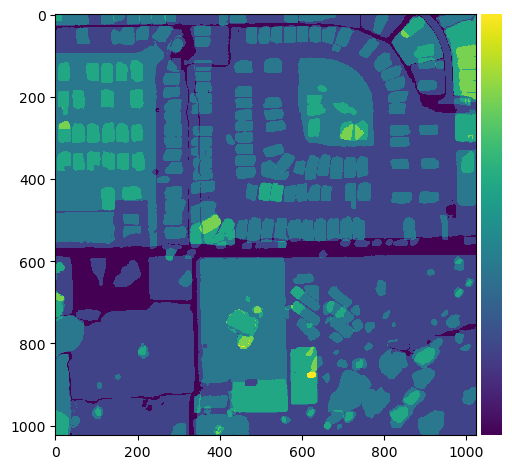

In [52]:
show_img(np.sum((np.stack(all_mask)), axis=0))

<Axes: >

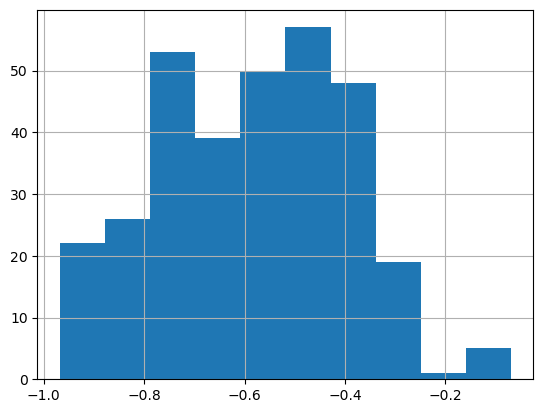

In [58]:
pd.Series(all_ci).hist()

In [25]:
np.quantile(all_ci, 0.25)

-0.7402088465530932

In [56]:
angle_chgt = [to_degre(_) for _ in all_ci]

<Axes: >

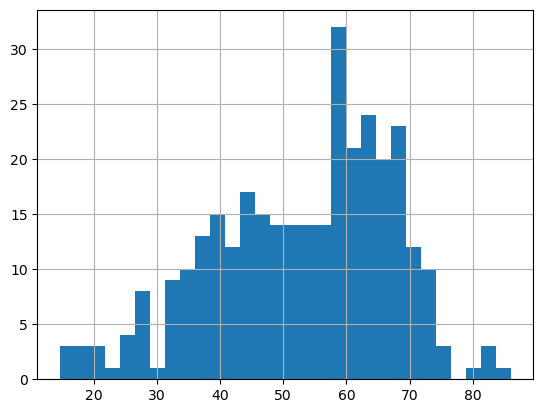

In [57]:
pd.Series(angle_chgt).hist(bins=30)

In [59]:
from skimage.filters import threshold_otsu

In [60]:
threshold_otsu(np.array(angle_chgt))

50.48126123142784

In [61]:
np.round(48.89, -1)

50.0

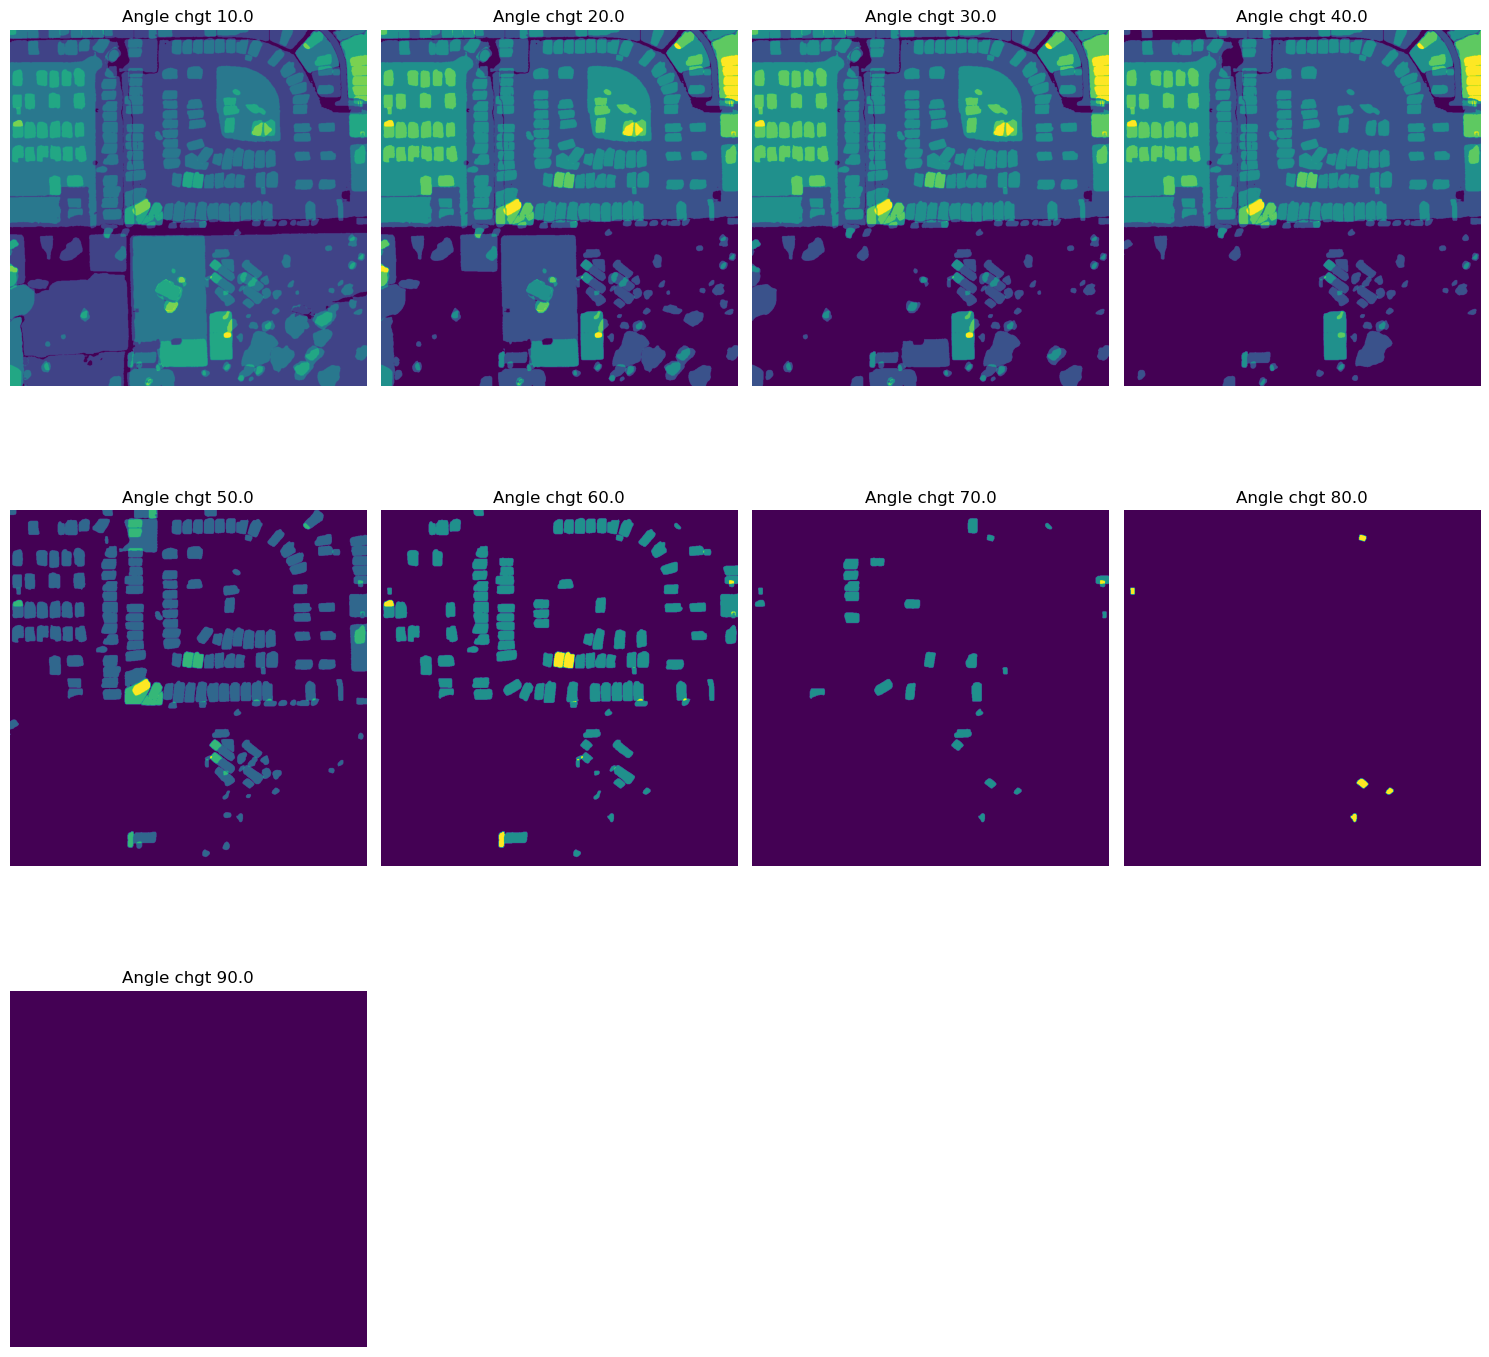

In [62]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.ravel()

angle_th = sorted(set([np.round(_.chgt_angle, -1) for _ in filter_items]))

_ = [axes[_].set_visible(False) for _ in [9, 10, 11]]

for i, a in enumerate(angle_th):
    mask_stack = np.zeros((1024, 1024))
    q_mask = [_.mask for _ in filter_items if _.chgt_angle >= a]
    if q_mask:
        mask_stack = np.sum((np.stack(q_mask)), axis=0)
    axes[i].imshow(mask_stack)
    axes[i].set_axis_off()
    axes[i].set_title(f"Angle chgt {a:.1f}")
    
plt.tight_layout()

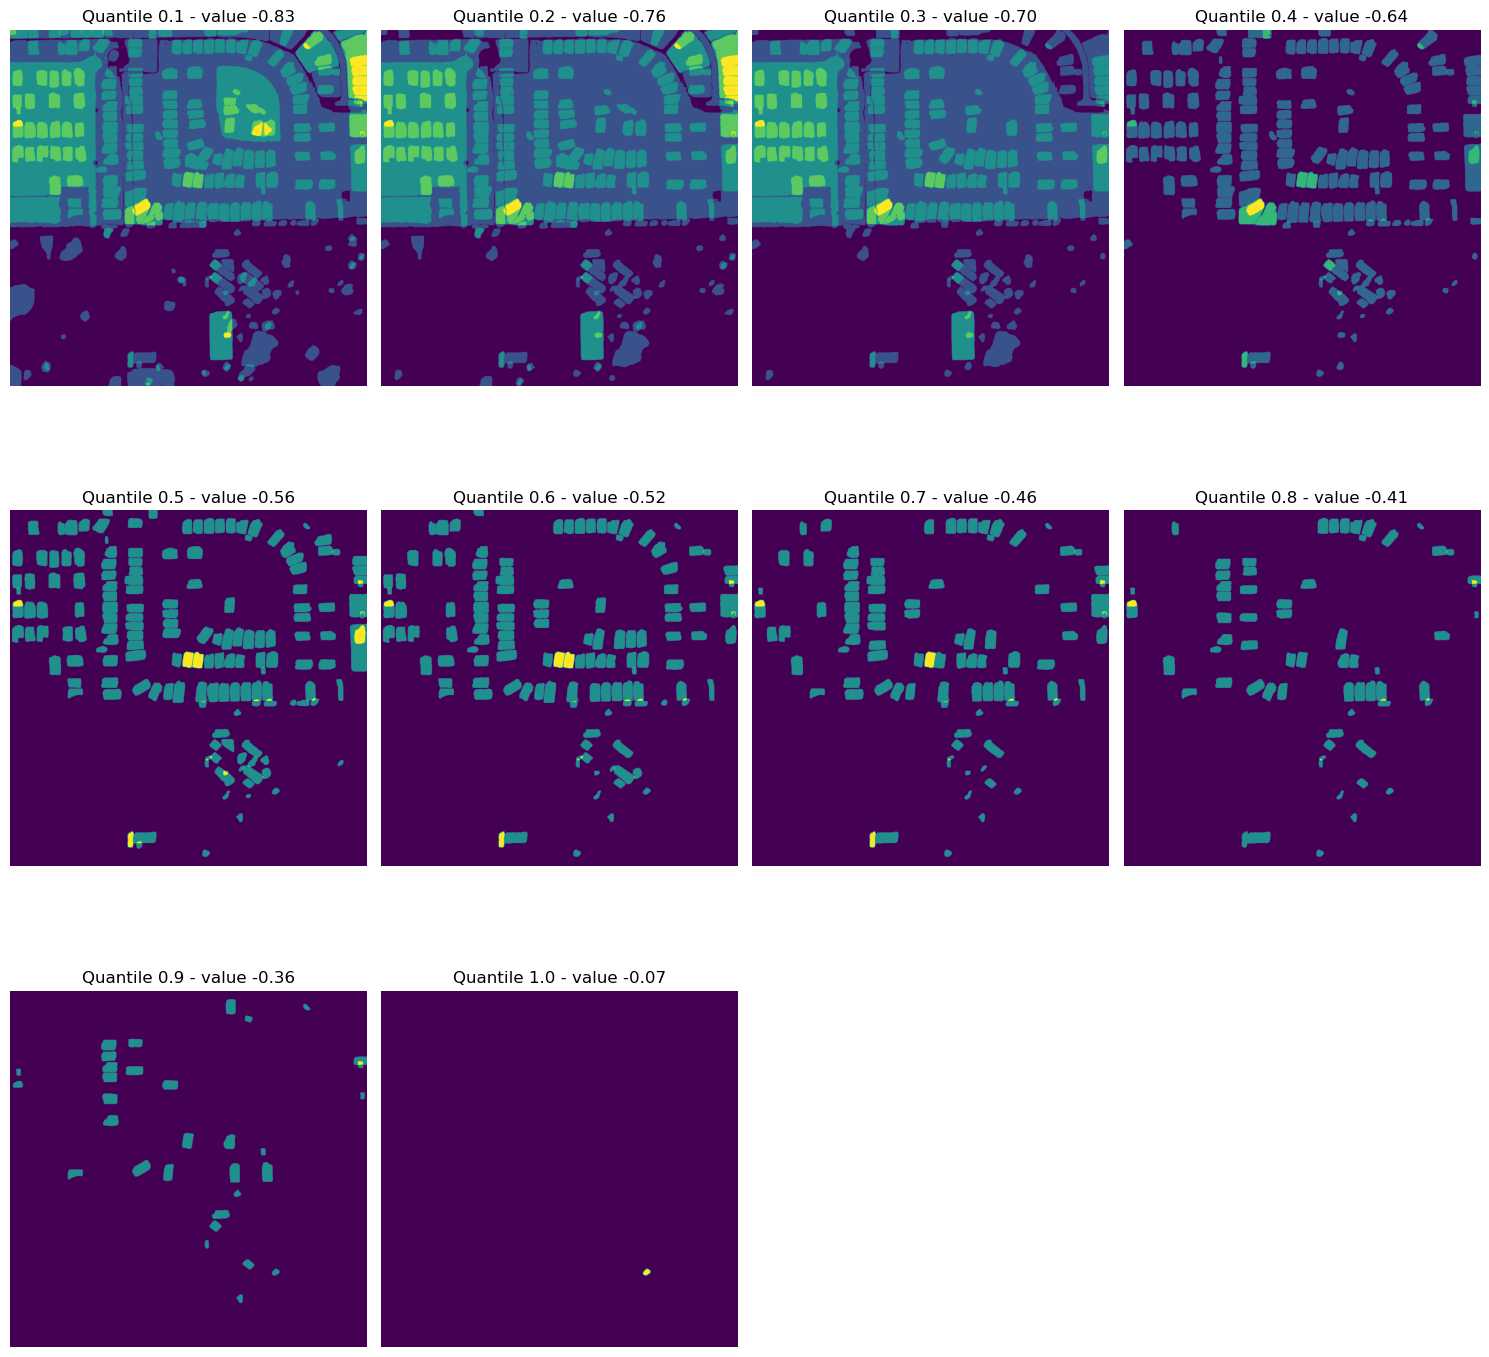

In [63]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.ravel()
_ = [axes[_].set_visible(False) for _ in [10, 11]]

for i, q in enumerate(np.linspace(0.1, 1, 10)):
    mask_stack = np.zeros((1024, 1024))
    v = np.quantile([_.confidence_score for _ in filter_items], q)
    q_mask = [_.mask for _ in filter_items if _.confidence_score >= v]
    if q_mask:
        mask_stack = np.sum((np.stack(q_mask)), axis=0)
    axes[i].imshow(mask_stack)
    axes[i].set_axis_off()
    axes[i].set_title(f"Quantile {q:.1f} - value {v:.2f}")
    
plt.tight_layout()

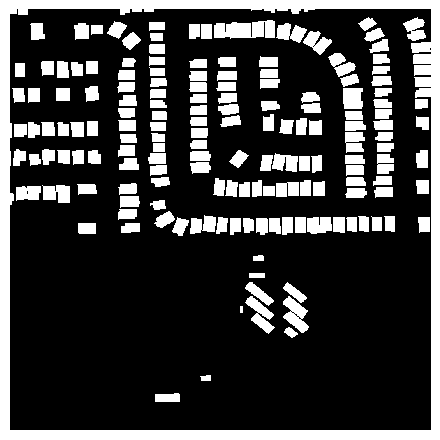

In [39]:
label = load_img(path_label)
show_img(label)

### Clustering changes